In [4]:
#Loading Libraries
from PIL import Image,ImageOps
import glob
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import fitz
import PyPDF2
from ipywidgets import interact
import ipywidgets as widgets
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract'
import re
import os
import pandas as pd

### Creating Images with Thin Sections from PDFs

In [ ]:
#Thin Section for Well 15_9-19A
#Each pdf page is saved separately
doc = fitz.open("15-9-19-A_Thin_section_micro_photograph_15_9-19A.pdf")
for i in range(2,len(doc),1):
    print('page', i)
    for img in doc.getPageImageList(i):
        xref = img[0]
        pix = fitz.Pixmap(doc, xref)
        suffix='fix_me'
        try:
            #print(i,img,xref)
            img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
            text = pytesseract.image_to_string(img)
            #print(text)
            depths = re.findall(r'[3-4]\d{3}\.\d{1,2}',text)
            #print(depths, len(depths))
            if len(depths) == 1:
                suffix=str(depths[0])+'_'+'fix_me'
            elif len(depths) == 2:
                suffix=str(depths[0])+'_'+str(depths[1])
        except:
            pass
        if pix.n < 5:       # this is GRAY or RGB
            pix.writePNG("15_9_19_A/15_9_19_A_p%s-%s-%s.png" % (i, xref, suffix))
        else:               # CMYK: convert to RGB first
            pix1 = fitz.Pixmap(fitz.csRGB, pix)
            pix1.writePNG("15_9_19_A/15_9_19_A_p%s-%s-%s.png" % (i, xref, suffix))
            pix1 = None
        pix = None

In [ ]:
#Thin Section for Well 15_9-19_bt2
#Each pdf page is saved separately
doc = fitz.open("15-9-19_bt2_Thin_section_micro_photograph_15_9-19-BT2.pdf")
for i in range(2,len(doc),1):
    print('page', i)
    for img in doc.getPageImageList(i):
        xref = img[0]
        pix = fitz.Pixmap(doc, xref)
        suffix='fix_me'
        try:
            #print(i,img,xref)
            img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
            text = pytesseract.image_to_string(img)
            #print(text)
            depths = re.findall(r'[3-4]\d{3}\.\d{1,2}',text)
            #print(depths, len(depths))
            if len(depths) == 1:
                suffix=str(depths[0])+'_'+'fix_me'
            elif len(depths) == 2:
                suffix=str(depths[0])+'_'+str(depths[1])
        except:
            pass
        if pix.n < 5:       # this is GRAY or RGB
            pix.writePNG("15_9_19_bt2/15_9_19_bt2_p%s-%s-%s.png" % (i, xref, suffix))
        else:               # CMYK: convert to RGB first
            pix1 = fitz.Pixmap(fitz.csRGB, pix)
            pix1.writePNG("15_9_19_bt2/15_9_19_bt2_p%s-%s-%s.png" % (i, xref, suffix))
            pix1 = None
        pix = None

### Extracting text with depth information from images

In [ ]:
def find_text(fileName,image_ext):
    #print(fileName[:-3]+image_ext)
    im = Image.open(fileName[:-3]+image_ext)
    text = pytesseract.image_to_string(im)
    depths = re.findall(r"[3-4]\d{3}[\,\.]\d{1,2}", text) #regular expression for depth
    return im, depths

In [ ]:
def fix_names(folderName):
    n_files_orig= len(glob.glob(folderName + "/*.png"))
    filePaths_bt2 = sorted(glob.glob(folderName + "/*fix_me.png"))
    for fileName in filePaths_bt2:
        im, depths = find_text(fileName,'png')
        if len(depths) > 0:
            if len(depths) == 1:
                suffix=str(depths[0])+'_'+'fix_me'
            elif len(depths) == 2:
                suffix=str(depths[0])+'_'+str(depths[1])
            new_filePath = (fileName[:-10]+suffix+'.png').replace(',','.')
            os.remove(fileName)
            im.save(new_filePath)
            print(new_filePath)
        else:
            print(fileName)
    n_files_final= len(glob.glob(folderName + "/*.png"))
    assert n_files_orig == n_files_final

In [ ]:
fix_names('15_9_19_A') #87 files, 74 still need to be fixed, 39 for both depths

In [ ]:
fix_names('15_9_19_bt2') #34 files, 19 still need to be fixed, 11 for both depths

### Extract 4 pictures from each page

In [14]:
def crop_array(image_data):
    
    sum_limit = 10000
    data=np.copy(image_data)
    data[data[:,:,0]>200]=0
    
    row_clusters = np.where(np.sum(data[:,:,0],axis=1)<sum_limit)[0]
    try:
        fig_top = np.max(row_clusters[row_clusters<20])
    except:
        fig_top=0
    try:
        fig_base = np.min(row_clusters[row_clusters>1750])
    except:
        fig_base=-1
        
    column_clusters = np.where(np.sum(data[:,:,0],axis=0)<sum_limit)[0]
    try:
        fig_left = np.max(column_clusters[column_clusters<20])
    except:
        fig_left=0
    try:
        fig_right = np.min(column_clusters[column_clusters>1150])
    except:
        fig_right=-1
    
    im_ = image_data[fig_top:fig_base,fig_left:fig_right,:]
    
    return im_

In [15]:
def devide_image(image_name, hist_plot=False):
    image = Image.open(image_name)
    data_orig = np.array(np.asarray(image))
    if hist_plot==True:
        plt.figure()
        plt.imshow(data_orig)
        
    sum_limit = 25000
    data=np.copy(data_orig)
    data[data[:,:,0]>200]=0
    
    row_clusters = np.where(np.sum(data[:,:,0],axis=1)<sum_limit)[0]
    try:
        fig1a_top = np.max(row_clusters[row_clusters<1000])
    except:
        fig1a_top=0
    fig1a_base = np.min(row_clusters[(row_clusters>1000) & (row_clusters<3000)])
    fig2a_top = np.max(row_clusters[(row_clusters>1000) & (row_clusters<3000)])
    fig2a_base = np.min(row_clusters[row_clusters>3000])
    
    if hist_plot==True:
        plt.figure()
        plt.hist(row_clusters, bins=500)
        plt.xlim([-10,data.shape[0]])
        plt.vlines(fig1a_top,0,10, colors='r', linestyles='dashed', label='Top image length starts at pizel '+str(fig1a_top))
        plt.vlines(fig1a_base,0,10, colors='r', linestyles='dotted', label='Top image length ends at pizel '+str(fig1a_base))
        plt.vlines(fig2a_top,0,10, colors='g', linestyles='dashed', label='Base image length starts at pizel '+str(fig2a_top))
        plt.vlines(fig2a_base,0,10, colors='g', linestyles='dotted', label='Base image length ends at pizel '+str(fig2a_base))
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel('pixels along image length with sums < 25000 in horizontal direction')
        
    column_clusters = np.where(np.sum(data[:,:,0],axis=0)<sum_limit)[0]
    try:
        fig1a_left = np.max(column_clusters[column_clusters<1000])
    except:
        fig1a_left=0
    fig1a_right = np.min(column_clusters[(column_clusters>1000) & (column_clusters<2000)])
    fig1b_left = np.max(column_clusters[(column_clusters>1000) & (column_clusters<2000)])
    fig1b_right = np.min(column_clusters[column_clusters>2000])

    if hist_plot==True:
        plt.figure()
        plt.hist(column_clusters, bins=500)
        plt.xlim([-10,data.shape[1]])

        plt.vlines(fig1a_left,0,10, colors='r', linestyles='dashed', label='Left image width starts at pizel '+str(fig1a_left))
        plt.vlines(fig1a_right,0,10, colors='r', linestyles='dotted', label='Left image width ends at pizel '+str(fig1a_right))
        plt.vlines(fig1b_left,0,10, colors='g', linestyles='dashed', label='Right image width starts at pizel '+str(fig1b_left))
        plt.vlines(fig1b_right,0,10, colors='g', linestyles='dotted', label='Right image width ends at pizel '+str(fig1b_right))
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel('pixels along image width with sums < 25000 in vertical direction')

    im_top_left = data_orig[fig1a_top:fig1a_base,fig1a_left:fig1a_right,:]
    im_top_right = data_orig[fig1a_top:fig1a_base,fig1b_left:fig1b_right,:]
    im_base_left = data_orig[fig2a_top:fig2a_base,fig1a_left:fig1a_right,:]
    im_base_right = data_orig[fig2a_top:fig2a_base,fig1b_left:fig1b_right,:]
    
    im_top_left = crop_array(im_top_left)
    im_top_right = crop_array(im_top_right)
    im_base_left = crop_array(im_base_left)
    im_base_right = crop_array(im_base_right)
    
    return im_top_left, im_top_right, im_base_left, im_base_right

(array([[[ 15,  17,  12],
         [ 16,  18,  13],
         [ 17,  19,  14],
         ...,
         [  5,  12,  18],
         [  6,  13,  19],
         [  5,  12,  18]],
 
        [[ 24,  24,  22],
         [ 22,  22,  20],
         [ 21,  21,  19],
         ...,
         [ 56,  63,  69],
         [ 58,  65,  71],
         [ 57,  64,  70]],
 
        [[ 17,  16,  14],
         [ 18,  17,  15],
         [ 18,  17,  15],
         ...,
         [105, 112, 118],
         [108, 115, 121],
         [108, 115, 121]],
 
        ...,
 
        [[221, 222, 214],
         [211, 213, 202],
         [200, 200, 188],
         ...,
         [217, 217, 217],
         [212, 212, 212],
         [213, 213, 211]],
 
        [[220, 227, 220],
         [214, 219, 212],
         [207, 210, 203],
         ...,
         [222, 223, 225],
         [225, 227, 226],
         [223, 225, 224]],
 
        [[225, 234, 229],
         [218, 227, 222],
         [212, 219, 212],
         ...,
         [233, 234, 236],
  

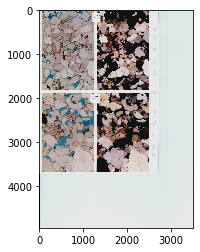

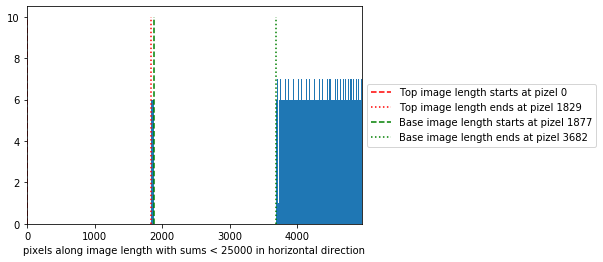

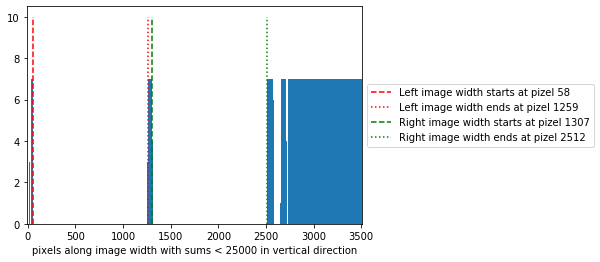

In [16]:
#Test cropping on one page
devide_image('15_9_19_A'+'/'+'15_9_19_A_p2-78-3837.55_3838.50.png',hist_plot=True)


In [17]:
folderName = '15_9_19_bt2'
folderName = '15_9_19_A'
filePaths = sorted(glob.glob(folderName + "/*.png"))
def show_cropped(i):

    print(filePaths[i])
    fig, axs = plt.subplots(2, 2, figsize = (5,7))

    im_top_left, im_top_right, im_base_left, im_base_right = devide_image(filePaths[i])
    axs[0,0].imshow(im_top_left)
    axs[0,1].imshow(im_top_right)
    axs[1,0].imshow(im_base_left)
    axs[1,1].imshow(im_base_right)
    
slider = widgets.IntSlider(value=0, min=0, max=len(filePaths)-1, step=1, description='file number')
interact(show_cropped, i=slider)

interactive(children=(IntSlider(value=0, description='file number', max=87), Output()), _dom_classes=('widget-…

<function __main__.show_cropped(i)>

In [21]:
cd "Step 1. Data Wrangling"

[WinError 2] The system cannot find the file specified: 'Step 1. Data Wrangling'
C:\Users\olyab\Documents\Training\Springboard_DataScienceTrack\CapstoneProjects\CapstoneProject2_ThinSections\Step 1. Data Wrangling


In [5]:
folderName = '15_9_19_A'
filePaths = sorted(glob.glob(folderName + "/*.png"))
left_A=[]
right_A=[]
name_A=[]
len_filename=len(filePaths[0])
for filePath in filePaths:
    print(filePath)
    im_top_left, im_top_right, im_base_left, im_base_right = devide_image(filePath)
    if len(filePath) + 5 >= len_filename:
        left_A.append(im_top_left)
        left_A.append(im_base_left)
        right_A.append(im_top_right)
        right_A.append(im_base_right)
        name_A.append(str.split(filePath,'-')[0]+'_'+str.split(str.split(filePath,'-')[-1],'_')[0]+'.png')
        name_A.append(str.split(filePath,'-')[0]+'_'+str.split(str.split(filePath,'-')[-1],'_')[1])
    else:
        left_A.append(im_top_left)
        right_A.append(im_top_right)
        name_A.append(str.split(filePath,'-')[0]+'_'+str.split(str.split(filePath,'-')[-1],'_')[0])

15_9_19_A\15_9_19_A_p10-36-3854.40_3855.50.png
15_9_19_A\15_9_19_A_p11-31-3856.40_3857.50.png
15_9_19_A\15_9_19_A_p12-26-3858.40_3859.50.png
15_9_19_A\15_9_19_A_p13-21-3860.15_3861.70.png
15_9_19_A\15_9_19_A_p14-16-3862.40_3863.00.png
15_9_19_A\15_9_19_A_p15-475-3867.15_3868.25.png
15_9_19_A\15_9_19_A_p16-470-3869.50_3870.40.png
15_9_19_A\15_9_19_A_p17-465-3871.50_3872.50.png
15_9_19_A\15_9_19_A_p18-460-3873.50_3874.40.png
15_9_19_A\15_9_19_A_p19-454-3875.50_3876.55.png
15_9_19_A\15_9_19_A_p2-78-3837.55_3838.50.png
15_9_19_A\15_9_19_A_p20-449-3877.55_3878.50.png
15_9_19_A\15_9_19_A_p21-444-3879.50_3880.00.png
15_9_19_A\15_9_19_A_p22-439-3881.45_3882.40.png
15_9_19_A\15_9_19_A_p23-433-3883.50_3884.50.png
15_9_19_A\15_9_19_A_p24-427-3885.55_3886.50.png
15_9_19_A\15_9_19_A_p25-422-3887.55_3888.50.png
15_9_19_A\15_9_19_A_p26-417-3889.55_3890.50.png
15_9_19_A\15_9_19_A_p27-412-3891.55_3892.50.png
15_9_19_A\15_9_19_A_p28-407-3893.50_3894.50.png
15_9_19_A\15_9_19_A_p29-401-3895.55_3896.50.png

In [6]:
print(len(left_A), len(right_A), len(name_A))

175 175 175


In [7]:
folderName = '15_9_19_bt2'
filePaths = sorted(glob.glob(folderName + "/*.png"))
left_bt2=[]
right_bt2=[]
name_bt2=[]
len_filename=len(filePaths[0])
for filePath in filePaths:
    print(filePath)
    im_top_left, im_top_right, im_base_left, im_base_right = devide_image(filePath)
    if len(filePath) + 5 >= len_filename:
        left_bt2.append(im_top_left)
        left_bt2.append(im_base_left)
        right_bt2.append(im_top_right)
        right_bt2.append(im_base_right)
        name_bt2.append(str.split(filePath,'-')[0]+'_'+str.split(str.split(filePath,'-')[-1],'_')[0]+'.png')
        name_bt2.append(str.split(filePath,'-')[0]+'_'+str.split(str.split(filePath,'-')[-1],'_')[1])
    else:
        left_bt2.append(im_top_left)
        right_bt2.append(im_top_right)
        name_bt2.append(str.split(filePath,'-')[0]+'_'+str.split(str.split(filePath,'-')[-1],'_')[0])

15_9_19_bt2\15_9_19_bt2_p10-146-4057.75_4058.75.png
15_9_19_bt2\15_9_19_bt2_p11-140--4059.75_4060.75.png
15_9_19_bt2\15_9_19_bt2_p12-135-4061.75_4062.75.png
15_9_19_bt2\15_9_19_bt2_p13-130-4063.75_4064.75.png
15_9_19_bt2\15_9_19_bt2_p14-125-4065.75_4066.75.png
15_9_19_bt2\15_9_19_bt2_p15-120--4067.75_4068.75.png
15_9_19_bt2\15_9_19_bt2_p16-114-4069.75_4070.75.png
15_9_19_bt2\15_9_19_bt2_p17-109-4071.75_4072.75.png
15_9_19_bt2\15_9_19_bt2_p18-104-4073.75_4074.75.png
15_9_19_bt2\15_9_19_bt2_p19-99-4075.75_4076.75.png
15_9_19_bt2\15_9_19_bt2_p2-187-4037.75_4038.75.png
15_9_19_bt2\15_9_19_bt2_p20-94-4077.75_4078.75.png
15_9_19_bt2\15_9_19_bt2_p21-88-4079.75_4080.75.png
15_9_19_bt2\15_9_19_bt2_p22-83-4081.45_4082.75.png
15_9_19_bt2\15_9_19_bt2_p23-78-4083.75_4084.75.png
15_9_19_bt2\15_9_19_bt2_p24-73-4085.75_4086.75.png
15_9_19_bt2\15_9_19_bt2_p25-68-4087.75_4088.75.png
15_9_19_bt2\15_9_19_bt2_p26-61--4089.70_4090.70.png
15_9_19_bt2\15_9_19_bt2_p27-56-4091.75_4092.75.png
15_9_19_bt2\15_9_19

In [8]:
print(len(left_bt2), len(right_bt2), len(name_bt2))

67 67 67


In [9]:
shape_A_left=[]
shape_A_right=[]
for i in range(len(left_A)):
    shape_A_left.append(left_A[i].shape)
    shape_A_right.append(right_A[i].shape)
shape_A_left = np.array(shape_A_left)
shape_A_right = np.array(shape_A_right)

In [10]:
shape_bt2_left=[]
shape_bt2_right=[]
for i in range(len(left_bt2)):
    shape_bt2_left.append(left_bt2[i].shape)
    shape_bt2_right.append(right_bt2[i].shape)
shape_bt2_left = np.array(shape_bt2_left)
shape_bt2_right = np.array(shape_bt2_right)

In [12]:
shape_A_left[:-1,0]

array([1800, 1801, 1808, 1799, 1800, 1803, 1806, 1805, 1795, 1800, 1801,
       1801, 1806, 1805, 1802, 1804, 1801, 1808, 1806, 1801, 1824, 1797,
       1798, 1805, 1799, 1797, 1797, 1799, 1794, 1804, 1804, 1806, 1794,
       1799, 1797, 1814, 1800, 1799, 1799, 1804, 1801, 1802, 1810, 1803,
       1800, 1804, 1803, 1800, 1800, 1799, 1795, 1803, 1801, 1796, 1793,
       1796, 1798, 1800, 1798, 1796, 1808, 1810, 1791, 1800, 1800, 1807,
       1806, 1809, 1795, 1798, 1799, 1800, 1798, 1798, 1798, 1805, 1800,
       1801, 1798, 1799, 1807, 1804, 1800, 1801, 1789, 1797, 1809, 1801,
       1805, 1798, 1818, 1796, 1801, 1802, 1807, 1798, 1799, 1800, 1807,
       1804, 1805, 1796, 1797, 1807, 1804, 1800, 1800, 1798, 1800, 1795,
       1802, 1802, 1801, 1796, 1809, 1807, 1802, 1801, 1798, 1800, 1803,
       1801, 1800, 1795, 1802, 1798, 1798, 1801, 1806, 1805, 1807, 1800,
       1810, 1814, 1802, 1802, 1808, 1801, 1802, 1804, 1797, 1803, 1802,
       1802, 1798, 1805, 1804, 1806, 1805, 1802, 18

In [13]:
shape_bt2_left[:-1,0]

array([1777, 1776, 1776, 1778, 1779, 1778, 1773, 1779, 1779, 1777, 1777,
       1778, 1775, 1780, 1778, 1782, 1781, 1776, 1773, 1780, 1772, 1777,
       1776, 1788, 1775, 1784, 1776, 1778, 1774, 1774, 1774, 1779, 1776,
       1779, 1777, 1775, 1775, 1778, 1773, 1778, 1782, 1778, 1776, 1773,
       1776, 1777, 1790, 1792, 1775, 1776, 1782, 1779, 1775, 1774, 1789,
       1774, 1775, 1772, 1779, 1776, 1777, 1772, 1778, 1775, 1779, 1776])

### Histogram of image lengths

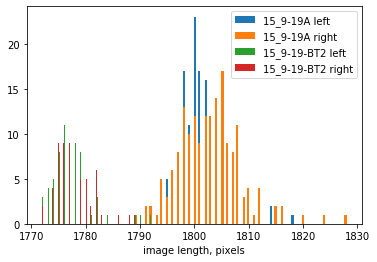

In [32]:
plt.hist(shape_A_left[:-1,0],bins=100, label='15_9-19A left')
plt.hist(shape_A_right[:-1,0],bins=100, label='15_9-19A right')
plt.hist(shape_bt2_left[:-1,0],bins=100, label='15_9-19-BT2 left')
plt.hist(shape_bt2_right[:-1,0],bins=100, label='15_9-19-BT2 right')
plt.xlabel('image length, pixels')
plt.legend()

In [15]:
#Standard width
size_width = int(round(np.concatenate([shape_A_left[:-1,0],shape_bt2_left[:-1,0]],axis=0).mean()))
size_width #1536 

1795

In [17]:
shape_A_left[:,1]

array([1194, 1197, 1195, 1199, 1197, 1199, 1193, 1201, 1195, 1199, 1196,
       1196, 1196, 1201, 1194, 1197, 1196, 1212, 1193, 1195, 1193, 1196,
       1195, 1200, 1196, 1194, 1193, 1195, 1192, 1201, 1196, 1203, 1192,
       1200, 1193, 1208, 1196, 1195, 1194, 1195, 1201, 1195, 1202, 1199,
       1199, 1205, 1196, 1195, 1193, 1194, 1196, 1204, 1194, 1194, 1194,
       1194, 1192, 1204, 1194, 1199, 1265, 1248, 1192, 1198, 1197, 1200,
       1200, 1206, 1191, 1197, 1191, 1198, 1194, 1202, 1200, 1205, 1192,
       1200, 1193, 1203, 1195, 1199, 1198, 1199, 1192, 1194, 1200, 1197,
       1193, 1199, 1206, 1194, 1194, 1194, 1205, 1196, 1194, 1196, 1205,
       1200, 1193, 1196, 1196, 1198, 1194, 1196, 1196, 1193, 1193, 1198,
       1193, 1196, 1205, 1200, 1201, 1204, 1203, 1197, 1192, 1194, 1201,
       1196, 1195, 1194, 1193, 1194, 1194, 1194, 1196, 1195, 1200, 1193,
       1213, 1217, 1196, 1193, 1195, 1195, 1202, 1198, 1197, 1198, 1203,
       1194, 1195, 1197, 1193, 1197, 1195, 1196, 12

In [18]:
shape_bt2_left[:,1]

array([1202, 1200, 1194, 1196, 1203, 1196, 1193, 1197, 1201, 1196, 1194,
       1197, 1198, 1196, 1194, 1197, 1203, 1195, 1193, 1193, 1196, 1194,
       1197, 1209, 1195, 1198, 1198, 1195, 1194, 1194, 1198, 1201, 1201,
       1197, 1196, 1195, 1193, 1197, 1197, 1198, 1195, 1195, 1197, 1199,
       1195, 1195, 1233, 1216, 1201, 1199, 1200, 1195, 1194, 1195, 1197,
       1196, 1199, 1197, 1199, 1200, 1194, 1196, 1197, 1199, 1197, 1195,
       1195])

### Histogram of image widths

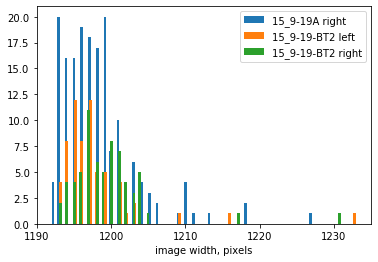

In [59]:
### plt.hist(shape_A_left[:,1],bins=100, label='15_9-19A left')
plt.hist(shape_A_right[:,1],bins=100, label='15_9-19A right')
plt.hist(shape_bt2_left[:,1],bins=100, label='15_9-19-BT2 left')
plt.hist(shape_bt2_right[:,1],bins=100, label='15_9-19-BT2 right')
plt.xlabel('image width, pixels')
plt.legend()

In [20]:
size_length = int(round(np.concatenate([shape_A_left[:,1],shape_bt2_left[:,1]],axis=0).mean()))
size_length #1536

1198

### Resizing images to standard size

In [11]:
#Standard image width
size_width=1536 #2048

In [12]:
#Standard image length
size_length = 1024

In [22]:
#Resizing images to standard width and length 
left_A_fixed_size = []
for i, im in enumerate(left_A):
    img = Image.fromarray(im)
    img = img.resize((size_length,size_width), Image.ANTIALIAS)
    file_name = name_A[i][:-4]+'_left.jpg'
    left_A_fixed_size.append(np.asarray(img))
    img.save(file_name) 

In [23]:
#Resizing images to standard width and length 
right_A_fixed_size = []
for i, im in enumerate(right_A):
    img = Image.fromarray(im)
    img = img.resize((size_length,size_width), Image.ANTIALIAS)
    file_name = name_A[i][:-4]+'_right.jpg'
    right_A_fixed_size.append(np.asarray(img))
    img.save(file_name) 

In [13]:
#Resizing images to standard width and length 
left_bt2_fixed_size = []
for i, im in enumerate(left_bt2):
    img = Image.fromarray(im)
    img = img.resize((size_length,size_width), Image.ANTIALIAS)
    file_name = name_bt2[i][:-4]+'_left.jpg'
    left_bt2_fixed_size.append(np.asarray(img))
    img.save(file_name) 

In [ ]:
#Resizing images to standard width and length 
right_bt2_fixed_size = []
for i, im in enumerate(right_bt2):
    img = Image.fromarray(im)
    img = img.resize((size_length,size_width), Image.ANTIALIAS)
    file_name = name_bt2[i][:-4]+'_right.jpg'
    right_bt2_fixed_size.append(np.asarray(img))
    img.save(file_name) 

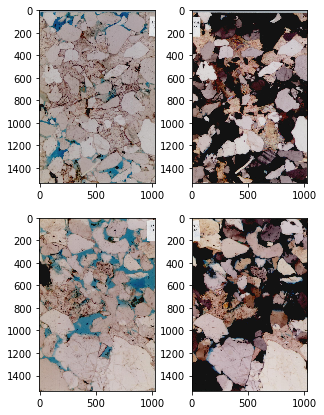

In [44]:
#Example of resized image
folderName = '15_9_19_bt2'
folderName = '15_9_19_A'

fig, axs = plt.subplots(2, 2, figsize = (5,7))

axs[0,0].imshow(Image.open(folderName+'/'+'15_9_19_A_p2_3837.55_left.jpg'))
axs[0,1].imshow(Image.open(folderName+'/'+'15_9_19_A_p2_3837.55_right.jpg'))
axs[1,0].imshow(Image.open(folderName+'/'+'15_9_19_A_p2_3838.50_left.jpg'))
axs[1,1].imshow(Image.open(folderName+'/'+'15_9_19_A_p2_3838.50_right.jpg'))


# Getting Labels

In [45]:
pwd

'C:\\Users\\olyab\\Documents\\Training\\Springboard_DataScienceTrack\\CapstoneProjects\\CapstoneProject2_ThinSections\\Step 1. Data Wrangling'

In [46]:
#Reading data for well 15919A into dataframe
na_values = ['NPP ','NMP ','  ']
df_15919A = pd.read_excel('15919A.xls',skiprows=[0,1,2],header=[0,1], na_values=na_values)
df_15919A.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 17 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   (Core no. , Unnamed: 0_level_1)                  728 non-null    int64  
 1   (Sample, no.)                                    728 non-null    int64  
 2   (Depth, (m))                                     728 non-null    float64
 3   (Kg, hor., (mD))                                 557 non-null    float64
 4   (1/Pm, hor., Unnamed: 4_level_1)                 557 non-null    float64
 5   (Kl, hor, (mD))                                  557 non-null    float64
 6   (Kg, vert., (mD))                                141 non-null    float64
 7   (1/Pm, vert., Unnamed: 7_level_1)                141 non-null    float64
 8   (Kl, vert., (mD))                                141 non-null    float64
 9   (Por., hor., (%))               

In [47]:
df_15919A.keys()

MultiIndex([(               'Core no. ',  'Unnamed: 0_level_1'),
            (                  'Sample',                 'no.'),
            (                   'Depth',                 '(m)'),
            (                'Kg, hor.',                '(mD)'),
            (              '1/Pm, hor.',  'Unnamed: 4_level_1'),
            (                 'Kl, hor',                '(mD)'),
            (               'Kg, vert.',                '(mD)'),
            (             '1/Pm, vert.',  'Unnamed: 7_level_1'),
            (               'Kl, vert.',                '(mD)'),
            (              'Por., hor.',                 '(%)'),
            (             'Por., vert.',                 '(%)'),
            (               'Por. sum.',                 '(%)'),
            (                      'So',                 '(%)'),
            (                      'Sw',                 '(%)'),
            (                'Gr.dens.',         'hor. (g/cc)'),
            (            

In [48]:
#Extracting usefull columns only
df_15919A_label = df_15919A.iloc[:, [2, 9]].astype('float')
df_15919A_label.columns = ["Depth, m","Porosity, pc"]
df_15919A_label

,"Depth, m","Porosity, pc"
0,3837.00,17.0
1,3837.25,14.8
2,3837.55,10.8
3,3837.80,12.8
4,3837.88,NaN
...,...,...
723,3998.85,28.9
724,3999.00,20.7
725,3999.25,20.9
726,3999.50,17.3


In [49]:
df_15919A_label["Porosity, pc"].unique()

array([17. , 14.8, 10.8, 12.8,  nan, 16.4, 16.5, 17.2, 16.9, 20.1, 10.3,
       12.7, 19. ,  9.9, 20.6, 21. , 22.7, 21.9, 20. , 22.1, 17.7, 11.6,
       19.6, 24.4, 25.8, 26.4, 24.9, 25.1, 25. , 24.3, 23.5, 36. , 24. ,
       23.6, 22.6, 18.3,  8.7, 15. , 24.1, 24.6, 22.5, 22. , 29.3, 23.8,
       23.2, 23.1, 23.9, 17.6, 14.7, 16.1,  9.2,  4. ,  3.8,  3.3,  7.3,
       19.7, 21.1,  8.6,  3.2,  8.5, 18.2, 23.4, 29.1, 15.8, 18.7, 20.3,
       19.1, 18.1, 19.9, 22.9, 33.8, 33.1, 24.8, 22.2, 22.3, 23.3, 24.7,
       25.9, 23. , 22.8, 22.4, 20.9, 21.4, 18.9, 15.2,  8.2,  5.4,  7.4,
       25.3, 29.9, 28.9, 25.4, 21.8, 12. , 14.1, 12.4,  9.7, 21.7, 21.2,
       21.5, 29. , 17.3, 17.1, 19.3, 19.2, 20.7, 21.3, 18.8, 20.2, 15.1,
       14.4, 16.8, 15.3, 16.2, 13.3, 31.3, 21.6, 17.4, 17.5, 26.3, 18.4,
       19.5, 17.8, 15.7, 18.6, 27.7, 11.4, 15.5, 24.5, 20.4, 19.4, 20.8,
       25.5, 24.2, 15.6,  4.3,  3.9,  5.3,  4.6,  5.1, 13.2,  4.7,  6.5,
        5.6,  6.7,  6.6,  7.8, 11.9, 14.5,  9.1,  3

In [50]:
df_15919A_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Depth, m      728 non-null    float64
 1   Porosity, pc  593 non-null    float64
dtypes: float64(2)
memory usage: 11.5 KB


In [51]:
#Removing rows with nans
df_15919A_label = df_15919A_label.dropna()

In [52]:
df_15919A_label.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 593 entries, 0 to 727
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Depth, m      593 non-null    float64
 1   Porosity, pc  593 non-null    float64
dtypes: float64(2)
memory usage: 13.9 KB


In [53]:
df_15919A_label.head(5)

,"Depth, m","Porosity, pc"
0,3837.00,17.0
1,3837.25,14.8
2,3837.55,10.8
3,3837.80,12.8
5,3838.00,16.4


In [57]:
well_A_data

,"Depth, m","Porosity, pc",File Name
0,3837.55,10.8,15_9_19_A\15_9_19_A_p2_3837.55.png
1,3838.50,17.2,15_9_19_A\15_9_19_A_p2_3838.50.png
2,3839.40,12.7,15_9_19_A\15_9_19_A_p3_3839.40.png
3,3840.45,21.0,15_9_19_A\15_9_19_A_p3_3840.45.png
4,3841.45,22.1,15_9_19_A\15_9_19_A_p4_3841.45.png
...,...,...,...
147,3995.50,18.2,15_9_19_A\15_9_19_A_p79_3995.50.png
148,3996.40,15.7,15_9_19_A\15_9_19_A_p79_3996.40.png
149,3997.50,11.7,15_9_19_A\15_9_19_A_p80_3997.50.png
150,3998.45,15.4,15_9_19_A\15_9_19_A_p80_3998.45.png


In [54]:
#Merging with filenames for thin sections
data=[]
for z in df_15919A_label['Depth, m']:
    #np.char.find(bar, str(z))
    mask = [str(z) in x for x in name_A]  
    if len(np.where(mask)[0])==1:
        data.append([name_A[np.where(mask)[0][0]],z])

df = pd.DataFrame(data, columns = ['File Name', 'Depth'])  
well_A_data = pd.merge(df_15919A_label,df,left_on='Depth, m',right_on='Depth')
well_A_data.pop('Depth')
well_A_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 0 to 151
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Depth, m      152 non-null    float64
 1   Porosity, pc  152 non-null    float64
 2   File Name     152 non-null    object 
dtypes: float64(2), object(1)
memory usage: 4.8+ KB


In [56]:
#Saving results to csv file
well_A_data.to_csv('DATA_for_DL_Well_A_data.csv')

In [18]:
#Reading data for well 15919A into dataframe
na_values = ['NPP ','NMP ','  ']
df_15919bt2 = pd.read_excel('15919bt2.xls',skiprows=[0,1,2],header=[0,1], na_values=na_values)
df_15919bt2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 17 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   (Core no. , Unnamed: 0_level_1)                  132 non-null    int64  
 1   (Sample, no.)                                    132 non-null    int64  
 2   (Depth, (m))                                     132 non-null    float64
 3   (Kg, hor., (mD))                                 130 non-null    float64
 4   (1/Pm, hor., Unnamed: 4_level_1)                 130 non-null    float64
 5   (Kl, hor, (mD))                                  130 non-null    float64
 6   (Kg, vert., (mD))                                0 non-null      float64
 7   (1/Pm, vert., Unnamed: 7_level_1)                0 non-null      float64
 8   (Kl, vert., (mD))                                0 non-null      float64
 9   (Por., hor., (%))               

In [ ]:
df_15919bt2_label = df_15919bt2.iloc[:, [2, 9]].astype('float')
df_15919bt2_label.columns = ["Depth, m","Porosity, pc"]
df_15919bt2_label

In [ ]:
df_15919bt2_label.info()

In [ ]:
#Merging with filenames for thin sections
data=[]
for z in df_15919bt2_label['Depth, m']:
    #np.char.find(bar, str(z))
    mask = [str(z) in x for x in name_bt2]  
    if len(np.where(mask)[0])==1:
        data.append([name_bt2[np.where(mask)[0][0]],z])

df = pd.DataFrame(data, columns = ['File Name', 'Depth'])  
well_bt2_data = pd.merge(df_15919bt2_label,df,left_on='Depth, m',right_on='Depth')
well_bt2_data.pop('Depth')
well_bt2_data.info()

In [ ]:
#Saving results to csv file
well_bt2_data.to_csv('DATA_for_DL-Well_bt2_data.csv')